<h1 align = "center"> Data Preprocessing

# Preprocessing steps : 

1. **Read data**
2. **Power transform**
3. **Data Normalization**
4. **Reshaping**
5. **Train/test/validation split** 

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from scipy.stats import normaltest

sns.set()

#path
import sys
sys.path.append("..")

import config
from src.features import eeg
from src.features import img
from src.utils.preprocessing import save_preprocessing_object

In [2]:
filename = "mnist-64s.csv"
csv_path = os.path.join(config.RAW_EEG_DIR,filename)
csv_path

'/home/michal/Desktop/ML_Projects/eeg2image/data/raw/EEG/mnist-64s.csv'

In [3]:
df = pd.read_csv(csv_path,index_col=0)
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
0,4193.333008,4185.127930,4188.205078,4183.589844,4141.538574,4185.641113,4188.717773,4185.127930,4191.281738,4254.358887,4176.922852,4184.102539,4176.410156,4187.692383,0,5
1,4200.000000,4183.589844,4190.769043,4183.589844,4160.512695,4182.051270,4182.563965,4183.589844,4192.307617,4238.461426,4184.102539,4186.153809,4173.846191,4178.461426,0,5
2,4190.769043,4189.743652,4187.692383,4188.717773,4178.461426,4190.256348,4188.717773,4176.410156,4190.256348,4245.127930,4176.410156,4184.615234,4174.871582,4171.281738,0,5
3,4180.512695,4182.563965,4187.179199,4180.512695,4177.948730,4183.589844,4181.025391,4182.051270,4187.179199,4284.102539,4177.948730,4185.641113,4179.487305,4176.410156,0,5
4,4186.666504,4184.102539,4189.743652,4185.127930,4187.692383,4185.641113,4184.102539,4198.974121,4189.230469,4273.333008,4189.230469,4188.205078,4183.076660,4182.051270,0,5


In [4]:
df.drop(labels="mnist_class",axis=1,inplace=True,errors="ignore")
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index
0,4193.333008,4185.127930,4188.205078,4183.589844,4141.538574,4185.641113,4188.717773,4185.127930,4191.281738,4254.358887,4176.922852,4184.102539,4176.410156,4187.692383,0
1,4200.000000,4183.589844,4190.769043,4183.589844,4160.512695,4182.051270,4182.563965,4183.589844,4192.307617,4238.461426,4184.102539,4186.153809,4173.846191,4178.461426,0
2,4190.769043,4189.743652,4187.692383,4188.717773,4178.461426,4190.256348,4188.717773,4176.410156,4190.256348,4245.127930,4176.410156,4184.615234,4174.871582,4171.281738,0
3,4180.512695,4182.563965,4187.179199,4180.512695,4177.948730,4183.589844,4181.025391,4182.051270,4187.179199,4284.102539,4177.948730,4185.641113,4179.487305,4176.410156,0
4,4186.666504,4184.102539,4189.743652,4185.127930,4187.692383,4185.641113,4184.102539,4198.974121,4189.230469,4273.333008,4189.230469,4188.205078,4183.076660,4182.051270,0


# Transform distribution

As we know from data analysis VAE needs data that comes from Gausian distribution. 

In order to complete this assumption I can use two type os solutions : 

- Data Science : Use data transformation and map the data into Gausian distribution based on KDE
- Deep learning : And random noise to intermediate layers during network initialization

In [5]:
sensors_list = df.columns[:14]

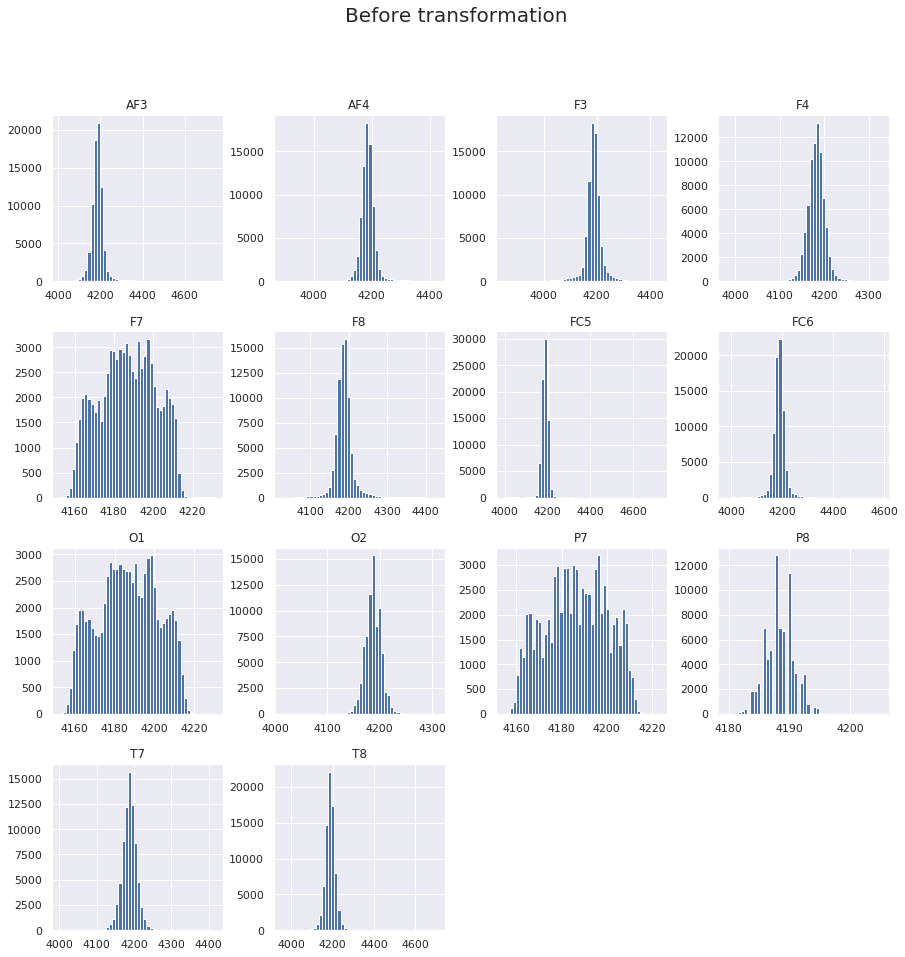

In [6]:
_ = df[sensors_list].hist(figsize=(15,15),bins=50)
_ = plt.suptitle("Before transformation",size = 20)

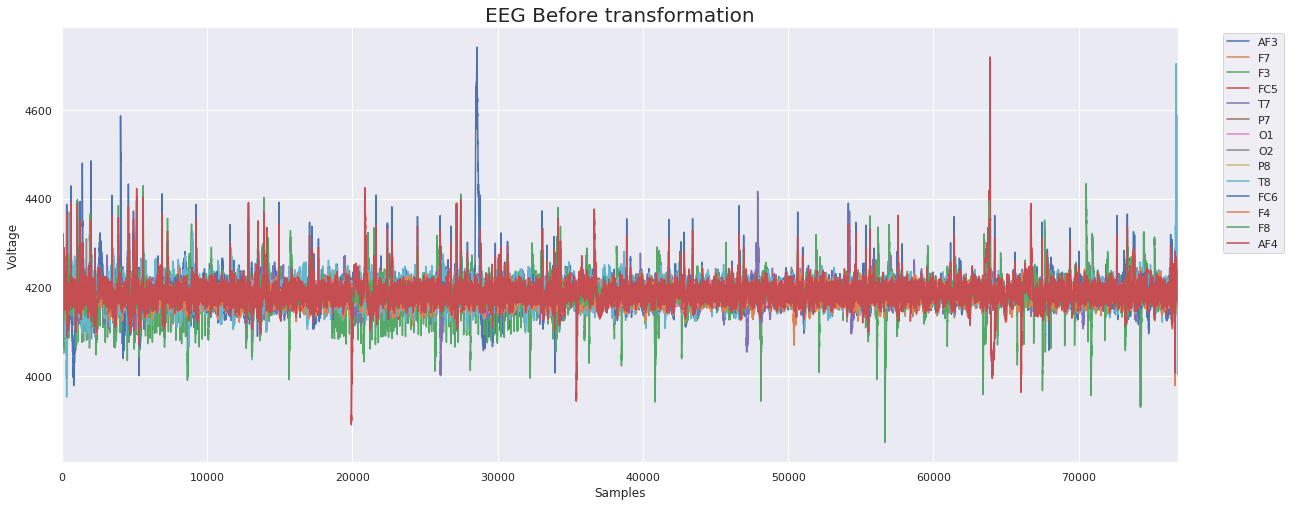

In [7]:
#Sprawdzić
_ = df[sensors_list].plot(figsize=(20,8)).legend(bbox_to_anchor=(1.1,1.0))
_ = plt.title("EEG Before transformation",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")

## Applying quantile transformation 

For this task **QuantileTransformer** was applied.

This scaller a non-linear transformation such that the probability density function of each feature will be mapped to a normal distribution distribution.

As RobustScaler, QuantileTransformer is robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data

In [8]:
"""
The transformation is applied on each feature independently.
First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution.
The obtained values are then mapped to the desired output distribution using the associated quantile function.
"""
df[sensors_list] = eeg.quantile_transformer(df[sensors_list])

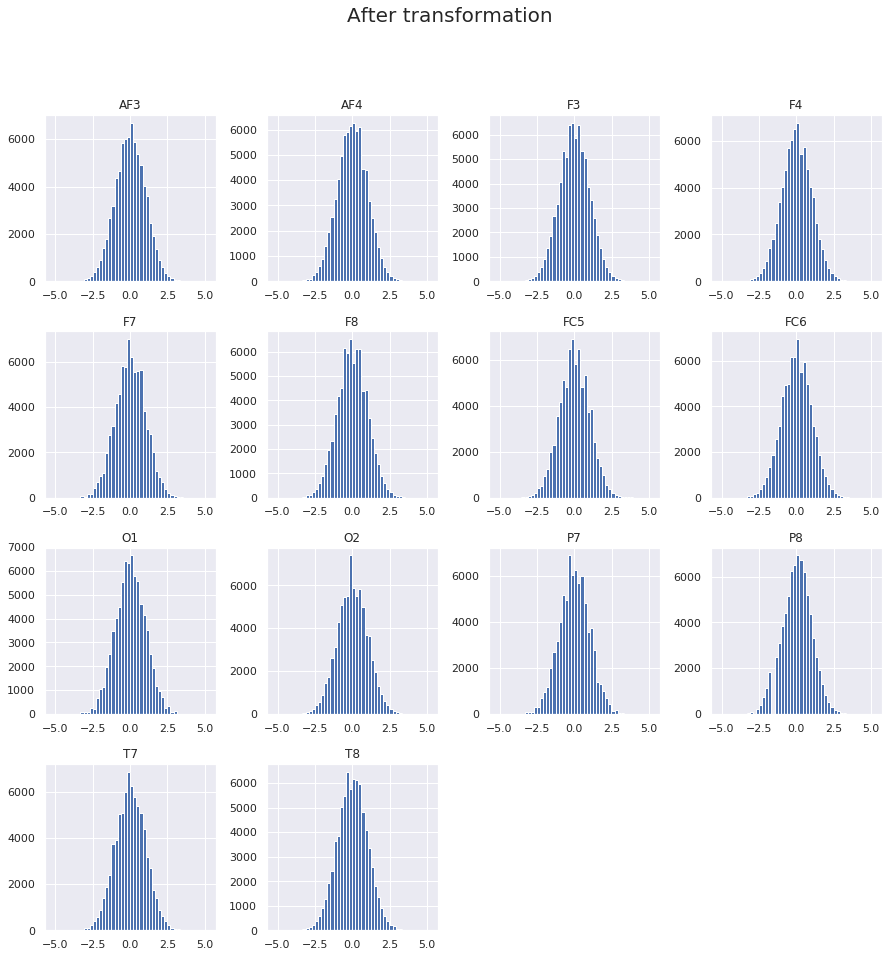

In [9]:
_ = df[sensors_list].hist(figsize=(15,15),bins=50)
_ = plt.suptitle("After transformation",size=20)

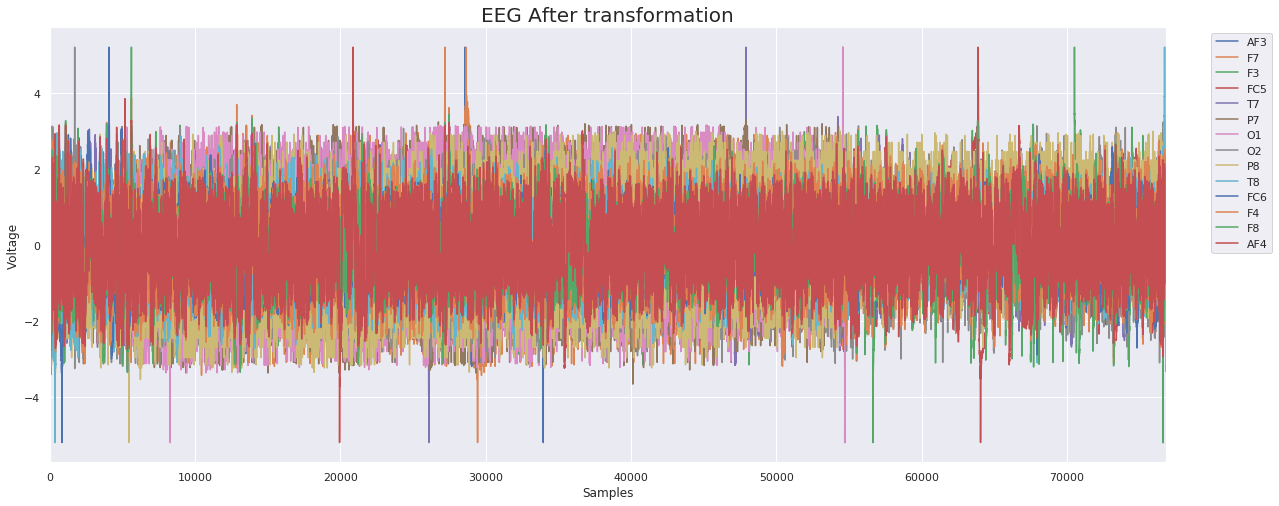

In [10]:
_ = df[sensors_list].plot(figsize=(20,8)).legend(bbox_to_anchor=(1.1,1.0))
_ = plt.title("EEG After transformation",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")

### Check hypothesis

To check if the electrode value distribution has a gauss distribution we need to perform statistical test.
For this particular situation **D’Agostino’s K^2 test** was selected

The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

Test Indicators : 

* **Skew** is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
* **Kurtosis** quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

Hypothesis : 
    
   * **H0**: the sample has a Gaussian distribution.
   * **H1**: the sample does not have a Gaussian distribution.

In [11]:
stat,p_list = normaltest(df[sensors_list].values)
for p in range(len(p_list)):
    val = p_list[p]
    sensor = df[sensors_list[p]].name
    if p > 0.05:
        print(f'Sensor {sensor} probably Gaussian')
    else:
        print(f'Sensor {sensor} Probably not Gaussian')

Sensor AF3 Probably not Gaussian
Sensor F7 probably Gaussian
Sensor F3 probably Gaussian
Sensor FC5 probably Gaussian
Sensor T7 probably Gaussian
Sensor P7 probably Gaussian
Sensor O1 probably Gaussian
Sensor O2 probably Gaussian
Sensor P8 probably Gaussian
Sensor T8 probably Gaussian
Sensor FC6 probably Gaussian
Sensor F4 probably Gaussian
Sensor F8 probably Gaussian
Sensor AF4 probably Gaussian


## Data normalization

### EEG

The basic assuption of the analysis was not to remove outliers because its not neccesary for deep learning architectures.In order to deal with problem we need to select appriopriate scalling method immune for outliers.

Scalers not immune for outliers 

* **StandardScaler**
* **MinMaxScaler** 
* **MaxAbsScaler**

Scalers not immune for outliers : 

* **Robust scaler**

Centering and scaling statistics of this scaler are **based on percentiles** and are therefore not influenced by a few number of very large marginal outliers. The problem with robust scaler is related with range of values. I need to transform data into uniform distribion. In order to do that i need to use  :


In [12]:
df[sensors_list], scaler = eeg.normalize(df[sensors_list])
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index
0,0.539051,0.489604,0.505070,0.477848,0.300509,0.496138,0.512461,0.485711,0.611270,0.717799,0.442306,0.513923,0.437466,0.509426,0
1,0.569875,0.480442,0.518328,0.477848,0.362962,0.473738,0.478343,0.471476,0.651939,0.691849,0.483879,0.525886,0.421850,0.459503,0
2,0.527014,0.516488,0.502534,0.514289,0.449653,0.522028,0.512461,0.426622,0.569248,0.704607,0.439244,0.516978,0.428226,0.423517,0
3,0.479332,0.473988,0.499879,0.456450,0.447146,0.483267,0.469326,0.458711,0.441437,0.747787,0.448265,0.522896,0.456317,0.448821,0
4,0.507851,0.483634,0.512827,0.488754,0.502172,0.496138,0.487173,0.574025,0.525761,0.739708,0.515754,0.537875,0.479085,0.478961,0


In [13]:
# as you can see during normalization step I use min max scaller 
df[sensors_list].agg(["min","max"])

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


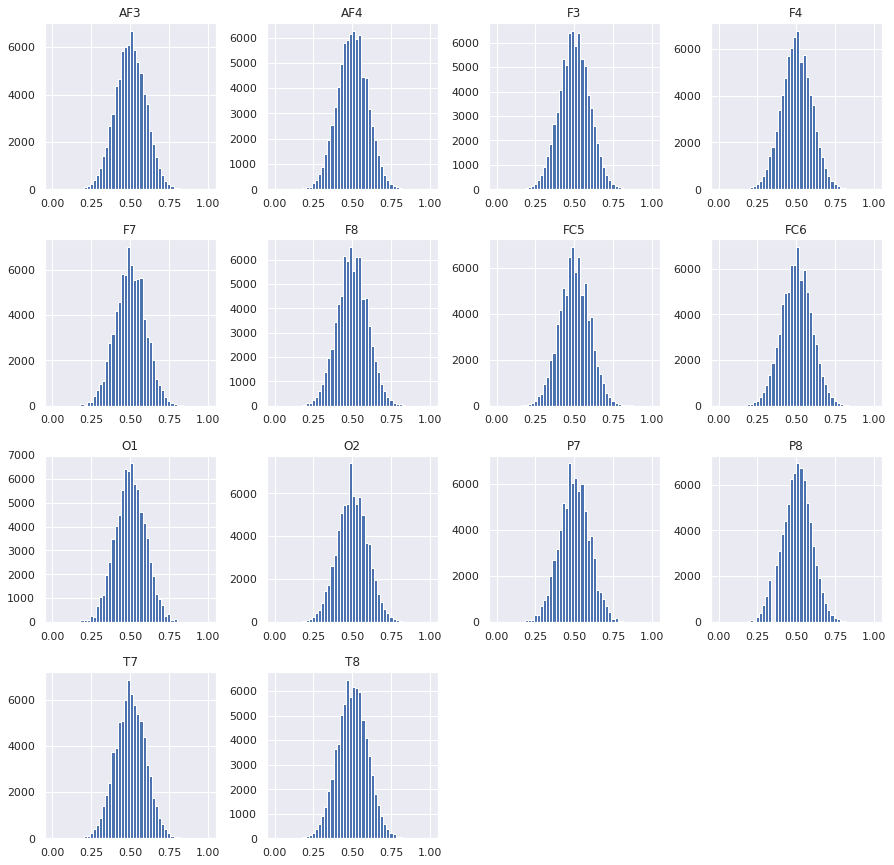

In [14]:
_ = df[sensors_list].hist(figsize=(15,15),bins=50)

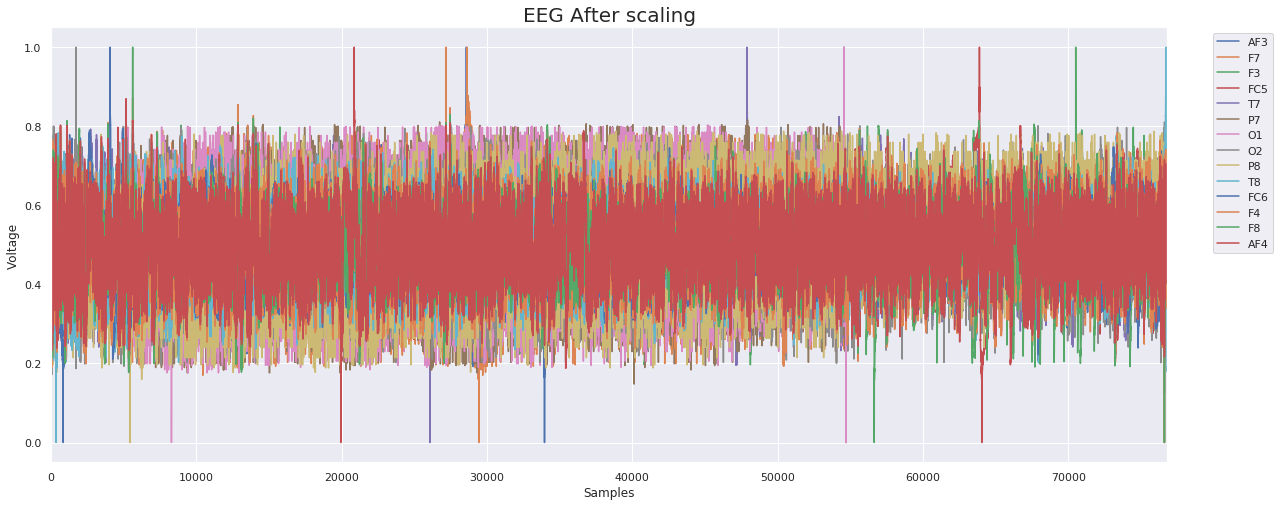

In [15]:
#Sprawdzić
_ = df[sensors_list].plot(figsize=(20,8)).legend(bbox_to_anchor=(1.1,1.0))
_ = plt.title("EEG After scaling",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")

## Save scaler

In [16]:
# save scaler for new samples
scaling_object = scaler
filepath = os.path.join(config.MODEL_DIR,"normalizer.h5")
save_preprocessing_object(scaling_object,filepath)

Object was saved into path /home/michal/Desktop/ML_Projects/eeg2image/models/normalizer.h5


### Visual Stimulus

In [241]:
from keras.datasets import mnist
(x_train, y_train), (_,_) = mnist.load_data()
x_train = x_train[0:1202]
y_train = y_train[0:1202]

In [242]:
x_train = img.normalize(x_train)

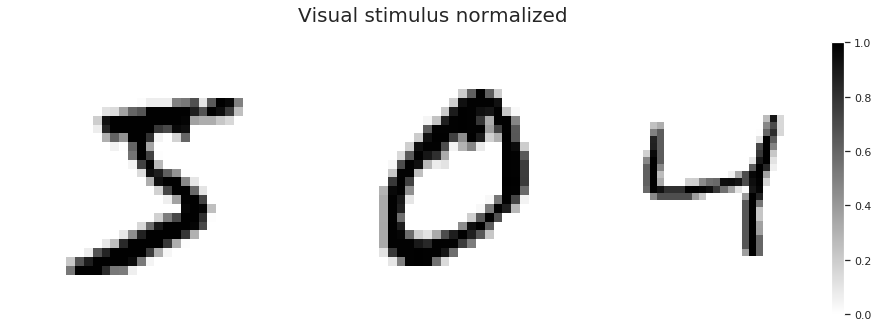

In [243]:
n_examples = 3
plt.figure(figsize=(15,5))

for i in range(n_examples):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.axis('off')

plt.suptitle("Visual stimulus normalized ",size = 20)
plt.grid(False)
plt.colorbar()

## Data reshaping

During this step I need to reshape data form suitable for Variational autoencoder. 
In order to do this I need to :

1. Batch EEG samples based on visual stimuly. (64 samples 1 image)
2. Reshape eeg and img to the same shape 
2. Flatten EEG signal (4 autoencoder input)
3. Flatten IMG samples (4 autoencoder input)
4. Perform train/test/validation split



In [244]:
mnist_indexes = df.mnist_index.value_counts()

In [245]:
eeg_batched = [df[df["mnist_index"]==i][sensors_list].values for i in range(len(mnist_indexes))]

In [246]:
images_batched = [x_train[i] for i in range(len(mnist_indexes))]

In [247]:
df2 = pd.DataFrame({"eeg" : eeg_batched,
                   "img" : images_batched})

In [248]:
df2.head()

,eeg,img
0,"[[0.5390510153693895, 0.4896041474235285, 0.50...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[0.6729703590480758, 0.4708455076672467, 0.62...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.5827725863656952, 0.48668642534727163, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[0.6515205115179952, 0.5083350654891129, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[0.38133473056380596, 0.5112457474567473, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Sposób 2 

Stracę mniej informacji z EEG 
1. Przerobić eeg na kształt 30 na 30
2. Przerobić obraz na kształt 30 na 30 
3. Jedno i drugie flatten

In [249]:
import cv2

In [250]:
# resize with interpolation to prefered shape
df2["eeg"] = df2["eeg"].apply(lambda x : cv2.resize(x,(30,30)))
df2["img"] = df2["img"].apply(lambda x : cv2.resize(x,(30,30)))

In [253]:
# Flatten to VAE Dense input
df2["eeg"] = df2["eeg"].apply(lambda x : x.flatten())
df2["img"] = df2["img"].apply(lambda x : x.flatten())

## Train-test-split

In [258]:
from sklearn.model_selection import train_test_split

In [259]:
X = df2.eeg.values
y = df2.img.values

In [263]:
#add dimension 
X = np.array([X[i] for i in range(len(X))]).squeeze()
y = np.array([y[i] for i in range(len(X))]).squeeze()

In [272]:
print(f"Features shape : {X.shape}")
print(f"Outputs  shape : {y.shape}")

Features shape : (1200, 900)
Outputs  shape : (1200, 900)


In [266]:
def train_test_validation_split(X,y,train_ratio = 0.75,test_ratio = 0.15,validation_ratio = 0.10 ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
    # train is now 75% of the entire data set
    # the _junk suffix means that we drop that variable completely

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set

    return X_train,X_test,X_val,y_train,y_test,y_val

In [267]:
X_train,X_test,X_val,y_train,y_test,y_val = train_test_validation_split(X,y)

In [268]:
print("Shapes info : \n")
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"X_valid shape : {X_val.shape}")

print(f"y_train shape : {y_train.shape}")
print(f"y_test shape : {y_test.shape}")
print(f"X_valid shape : {y_val.shape}")


Shapes info : 

X_train shape : (900, 900)
X_test shape : (180, 900)
X_valid shape : (120, 900)
y_train shape : (900, 900)
y_test shape : (180, 900)
X_valid shape : (120, 900)


In [270]:
np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"X_train"),X_train)
np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"X_test"),X_test)
np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"X_valid"),X_val)

np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"y_train"),y_train)
np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"y_test"),y_test)
np.save(os.path.join(config.DATA_PREPROCESSED_DIR,"y_valid"),y_val)